# 一些准备工作

In [2]:
import gc
import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold,StratifiedKFold,GroupKFold,TimeSeriesSplit
from performance_optimizing import performance_optimizing as po

注意无论平时工作还是比赛，进行测试的时候一定要把随机性控制住，使用这个seed_everthing 的函数基本可以控制住常见的数据挖掘过程中的随机性了，如果涉及到tensorflow或keras或者pytorch，还需要针对其进行额外的随机性的控制

In [2]:
import os
import random
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(123)

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))


In [4]:
cat=pd.read_csv('cat.csv')
cat=cat.cat.values.tolist()
params = {'num_leaves': 491,
          'colsample_bytree': 0.75,
          'subsample': 0.75,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.45,
          'reg_lambda': 0.65,
          'random_state': 47,
          'n_jobs':-1,
          'n_estimators':10000,
         }

In [5]:
cat

['ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo',
 'P_emaildomain',
 'R_emaildomain']

In [6]:

def lgb_model(params=None,cv=KFold(5),X=None,X_test=None,columns=None,early_stopping_rounds=200, \
              cols=None,categorical_feature=None,group_feature=None):


    #folds = StratifiedKFold(n_splits=NFOLDS)
    folds =cv
    if cols==None:
        columns = list(X.columns)
    else:
        columns=cols
    if group_feature:
        columns.remove(group_feature)
        splits = folds.split(X[columns], y,groups=X[group_feature])
    else:
        splits = folds.split(X[columns], y)
    y_oof = np.zeros(X.shape[0])
    score = 0


    clfs=[]
    for fold_n, (train_index, valid_index) in enumerate(splits):
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]


        clf = lgb.LGBMClassifier(**params)
        clf.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_valid,y_valid)], \
                 eval_metric='auc', verbose=100, early_stopping_rounds=early_stopping_rounds,categorical_feature=categorical_feature)


        y_pred_valid = clf.predict_proba(X_valid)[:,1]
        y_oof[valid_index] = y_pred_valid
        print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")

        score += roc_auc_score(y_valid, y_pred_valid) / 5

        del X_train, X_valid, y_train, y_valid
        gc.collect()
        clfs.append(clf)

    print(f"\nMean AUC = {score}")
    print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")
    return clfs

因为cat已经记录了原始数据中的类别特征是哪些了，通过为lightgbm指定category_feature即可，所以我们先对原始的类别特征进行编码处理，用int型数据来保存，这样可以大大降低内存占用以及提高读写的速度

## 数据类型优化降低内存占用

需要注意的细节是，这里我们对类别特征使用了标签编码，缺失值直接指定为-1，也就是将缺失的部分当作“缺失类”考虑进去

In [7]:
for col in cat:
    po.cat2int(col,X,X_test)

ProductCD , card1 , card2 , card3 , card4 , card5 , card6 , addr1 , addr2 , M1 , M2 , M3 , M4 , M5 , M6 , M7 , M8 , M9 , id_12 , id_13 , id_14 , id_15 , id_16 , id_17 , id_18 , id_19 , id_20 , id_21 , id_22 , id_23 , id_24 , id_25 , id_26 , id_27 , id_28 , id_29 , id_30 , id_31 , id_32 , id_33 , id_34 , id_35 , id_36 , id_37 , id_38 , DeviceType , DeviceInfo , 

In [6]:
for col in ['P_emaildomain',
 'R_emaildomain']:
    po.cat2int(col,X,X_test)

P_emaildomain , R_emaildomain , 

In [8]:
others=list(set(X.columns)-set(cat))

In [9]:
po.reduce_mem_usage(X,others)

Mem. usage decreased to 527.14 Mb (70.7% reduction)


In [10]:
po.reduce_mem_usage(X_test,others)

Mem. usage decreased to 459.54 Mb (70.1% reduction)


In [9]:
dtypes=pd.DataFrame(X.dtypes)

In [11]:
dtypes.to_csv('dtypes.csv')

处理完毕的数据进行保存

In [7]:
X.to_csv('X.csv',index=False)
X_test.to_csv('X_test.csv',index=False)


# 确定交叉验证的方式

## StratifiedKFold

In [18]:
clfs=lgb_model(params=params,cv=StratifiedKFold(5),X=X,X_test=X_test,early_stopping_rounds=200,categorical_feature=cat)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.970525	valid_1's auc: 0.870907
[200]	training's auc: 0.984701	valid_1's auc: 0.875924
[300]	training's auc: 0.991496	valid_1's auc: 0.874564
Early stopping, best iteration is:
[171]	training's auc: 0.981575	valid_1's auc: 0.87765
Fold 1 | AUC: 0.8776495288500892
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.967389	valid_1's auc: 0.901537
[200]	training's auc: 0.983324	valid_1's auc: 0.905095
[300]	training's auc: 0.991021	valid_1's auc: 0.900565
[400]	training's auc: 0.995303	valid_1's auc: 0.890137
Early stopping, best iteration is:
[227]	training's auc: 0.985919	valid_1's auc: 0.905993
Fold 2 | AUC: 0.9059934678604471
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.968553	valid_1's auc: 0.908253
[200]	training's auc: 0.984142	valid_1's auc: 0.918403
[300]	training's auc: 0.991361	valid_1's auc: 0.921004
[400]	training's au

In [19]:
y_preds=np.zeros(X_test.shape[0])
for clf in clfs:
    y_preds+=clf.predict_proba(X_test)[:,1]
sub=pd.read_csv('sample_submission.csv')
sub['isFraud']=y_preds
sub.to_csv('./submit/sub_stratifiedkfold.csv',index=False)

## KFold

In [20]:
clfs=lgb_model(params=params,cv=KFold(5),X=X,X_test=X_test,early_stopping_rounds=200,cols=None,categorical_feature=cat)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.967689	valid_1's auc: 0.883455
[200]	training's auc: 0.98287	valid_1's auc: 0.888501
[300]	training's auc: 0.989902	valid_1's auc: 0.891704
[400]	training's auc: 0.994226	valid_1's auc: 0.894974
[500]	training's auc: 0.996787	valid_1's auc: 0.897366
[600]	training's auc: 0.998147	valid_1's auc: 0.899755
[700]	training's auc: 0.998918	valid_1's auc: 0.901197
[800]	training's auc: 0.999371	valid_1's auc: 0.902284
[900]	training's auc: 0.999639	valid_1's auc: 0.902604
[1000]	training's auc: 0.9998	valid_1's auc: 0.903494
[1100]	training's auc: 0.999891	valid_1's auc: 0.904437
[1200]	training's auc: 0.999942	valid_1's auc: 0.904857
[1300]	training's auc: 0.999969	valid_1's auc: 0.905255
[1400]	training's auc: 0.999984	valid_1's auc: 0.905521
[1500]	training's auc: 0.999992	valid_1's auc: 0.905833
[1600]	training's auc: 0.999996	valid_1's auc: 0.906065
[1700]	training's auc: 0.999998	valid_1's auc: 0.90638

In [21]:
y_preds=np.zeros(X_test.shape[0])
for clf in clfs:
    y_preds+=clf.predict_proba(X_test)[:,1]
sub=pd.read_csv('sample_submission.csv')
sub['isFraud']=y_preds
sub.to_csv('./submit/sub_kfold.csv',index=False)

## 时间序列交叉验证 TimeSeriesSplit

In [22]:
clfs=lgb_model(params=params,cv=TimeSeriesSplit(5),X=X,X_test=X_test,early_stopping_rounds=200,cols=None,categorical_feature=cat)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.982009	valid_1's auc: 0.878758
[200]	training's auc: 0.994292	valid_1's auc: 0.880891
[300]	training's auc: 0.99839	valid_1's auc: 0.882239
[400]	training's auc: 0.99962	valid_1's auc: 0.882654
[500]	training's auc: 0.999918	valid_1's auc: 0.88384
[600]	training's auc: 0.999983	valid_1's auc: 0.885374
[700]	training's auc: 0.999997	valid_1's auc: 0.88579
[800]	training's auc: 0.999999	valid_1's auc: 0.886357
[900]	training's auc: 1	valid_1's auc: 0.886145
[1000]	training's auc: 1	valid_1's auc: 0.885963
Early stopping, best iteration is:
[804]	training's auc: 1	valid_1's auc: 0.886406
Fold 1 | AUC: 0.8862647786854643
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.981721	valid_1's auc: 0.899393
[200]	training's auc: 0.993454	valid_1's auc: 0.910388
[300]	training's auc: 0.997867	valid_1's auc: 0.91433
[400]	training's auc: 0.99932	valid_1's auc: 0.91402
[500]	trai

In [23]:
y_preds=np.zeros(X_test.shape[0])
for clf in clfs:
    y_preds+=clf.predict_proba(X_test)[:,1]
sub=pd.read_csv('sample_submission.csv')
sub['isFraud']=y_preds
sub.to_csv('./submit/sub_timeseriesfold.csv',index=False)

可以看到，对于时序问题，交叉验证的方式会起到很大的影响，主要是因为不同交叉验证的方式会导致不同程度的时间穿越问题

## GroupKFold

最后尝试一下groupby

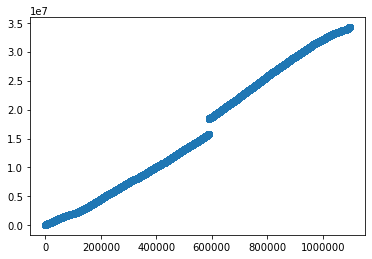

In [24]:
import matplotlib.pyplot as plt
transactiondt=X.TransactionDT.values.tolist()+X_test.TransactionDT.values.tolist()
plt.scatter(list(range(len(transactiondt))),transactiondt)

根据transactiondt的值的大小，看起来像是以秒为单位的时间戳，我们把首尾的值相减算出时间间隔然后将秒转化为天看看结果：

In [25]:
(max(transactiondt)-min(transactiondt))/(3600*24)

394.99936342592594

从数值上看是比较合理的，因为本身这些属于来源于信用卡，相对来说属于比较小额的交易，不像房贷这种大额贷款 数据周期跨度长，394天大概是一年多一点的周期长度很正常，之前遇到的小额贷款问题大都是1~2年期跨度之间的

所以接下来我们就可以假定一个初始日期，来确定具体的时间，时间的绝对大小并不是很重要，重要的是时间的相对间隔与其反映出来的周期性

In [15]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X['DT_M'] = X['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X['DT_M'] = (X['DT_M'].dt.year-2017)*12 + X['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

In [27]:
X.DT_M

0         12
1         12
2         12
3         12
4         12
          ..
590535    17
590536    17
590537    17
590538    17
590539    17
Name: DT_M, Length: 590540, dtype: int64

In [28]:
clfs=lgb_model(params=params,cv=GroupKFold(5),X=X,X_test=X_test,early_stopping_rounds=200,cols=None,categorical_feature=cat,group_feature='DT_M')

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.969036	valid_1's auc: 0.870002
[200]	training's auc: 0.983272	valid_1's auc: 0.877622
[300]	training's auc: 0.990389	valid_1's auc: 0.883028
[400]	training's auc: 0.994637	valid_1's auc: 0.886177
[500]	training's auc: 0.997049	valid_1's auc: 0.888027
[600]	training's auc: 0.998322	valid_1's auc: 0.889045
[700]	training's auc: 0.999044	valid_1's auc: 0.889514
[800]	training's auc: 0.999451	valid_1's auc: 0.890003
[900]	training's auc: 0.99969	valid_1's auc: 0.890556
[1000]	training's auc: 0.99983	valid_1's auc: 0.890981
[1100]	training's auc: 0.999909	valid_1's auc: 0.891246
[1200]	training's auc: 0.999953	valid_1's auc: 0.891588
[1300]	training's auc: 0.999976	valid_1's auc: 0.891736
[1400]	training's auc: 0.999988	valid_1's auc: 0.891882
[1500]	training's auc: 0.999994	valid_1's auc: 0.892259
[1600]	training's auc: 0.999997	valid_1's auc: 0.892906
[1700]	training's auc: 0.999998	valid_1's auc: 0.8932

In [35]:
X_test.columns

Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo', 'had_id', 'DT_M'],
      dtype='object', length=434)

In [36]:
y_preds=np.zeros(X_test.shape[0])
for clf in clfs:
    y_preds+=clf.predict_proba(X_test.drop('DT_M',axis=1))[:,1]
sub=pd.read_csv('sample_submission.csv')
sub['isFraud']=y_preds
sub.to_csv('./submit/sub_groupkfold.csv',index=False)

# 对比：local cv 和线上成绩

1、StratifiedKFold
Mean AUC = 0.9163691077037969

2、KFold
Mean AUC = 0.9285080041641682

3、TimeSeriesSplit
Mean AUC = 0.9141553597311398

4、GroupKFold
Mean AUC = 0.9283666660666199

主要是看mean auc，out of folds auc 参考意义不大因为不同的fold产生的model可能树的数量差异性比较大，那么进行分别预测其预测值的整体范围会有一定差距，导致 out of folds结果不准，所以实际上预测的时候需要对每一个基模型的输出进行一下尺度的变换，比如使用rank平均，使用0-1标准化尽量减少不同基模型预测值之间的差距

然后我们看看不同交叉验证的线上成绩如何

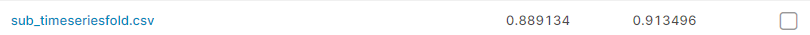

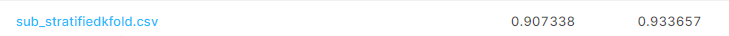

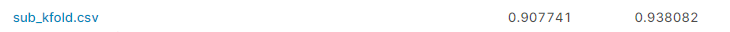

右边是A榜，左边是B榜，我们目前假设还在A榜，可以看到group和kfold相差不大，二者和stratifiedkfold相差较多，所以后续我们需要同时使用group和kfold两种交叉验证的方式进行比较得分

然后我们保存一下周期DT_M，以及groupkfold下的5个模型用于后续的特征重要性分析

In [16]:
X.to_csv('X.csv',index=False)
X_test.to_csv('X_test.csv',index=False)
y.to_csv('y.csv',index=False)
pd.DataFrame(X.dtypes).to_csv('dtypes.csv',index=False)
X.DT_M.to_csv('X_DT_M.csv')

for i,clf in enumerate(clfs):
    joblib.dump(clf,'./output/model'+'//'+str(i)+'_th '+'model '+'.pkl')